In [2]:
from dotenv import load_dotenv
import os
load_dotenv()


True

In [6]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool

urls = [
  "https://en.wikipedia.org/wiki/Viscosity"
]

def retrive_url(urls):
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=100, chunk_overlap=50
    )
    doc_splits = text_splitter.split_documents(docs_list)

    embeddings_model = AzureOpenAIEmbeddings(
        model = "text-embedding-3-large",
        openai_api_version=os.environ.get("AZURE_OPENAI_API_VERSION"),
        azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
        api_key=os.environ.get("AZURE_OPENAI_KEY")
    )

    # Add to vectorDB
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embeddings_model,
    )
    retriever = vectorstore.as_retriever()



    retriever_tool = create_retriever_tool(
        retriever,
        "retrieve_blog_posts",
        "Search and return information about viscosity"
    )

    return retriever_tool

retrieval_tool = retrive_url(urls)
tools = [retrieval_tool]

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [5]:

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver


class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        # Define a new graph
        graph = StateGraph(AgentState)

        # Define the nodes we will cycle between
        graph.add_node("agent", self.agent)  # agent
        retrieve = ToolNode(tools)
        graph.add_node("retrieve", retrieve)  # retrieval
        graph.add_node("rewrite", self.rewrite)  # Re-writing the question
        graph.add_node(
            "generate", self.generate
        )  # Generating a response after we know the documents are relevant
        # Call agent node to decide to retrieve or not
        graph.add_edge(START, "agent")

        # Decide whether to retrieve
        graph.add_conditional_edges(
            "agent",
            # Assess agent decision
            tools_condition,
            {
                "tools": "retrieve",
                END: END,
            },
        )

        # Edges taken after the `action` node is called.
        graph.add_conditional_edges(
            "retrieve",
            # Assess agent decision
            self.grade_documents,
        )
        graph.add_edge("generate", END)
        graph.add_edge("rewrite", "agent")


        self.graph = graph.compile(checkpointer=checkpointer)


        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
    

    def grade_documents(self,state) -> Literal["generate", "rewrite"]:
        """
        Determines whether the retrieved documents are relevant to the question.

        Args:
            state (messages): The current state

        Returns:
            str: A decision for whether the documents are relevant or not
        """

        print("---CHECK RELEVANCE---")

        # Data model
        class grade(BaseModel):
            """Binary score for relevance check."""

            binary_score: str = Field(description="Relevance score 'yes' or 'no'")

        # LLM
        model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

        # LLM with tool and validation
        llm_with_tool = model.with_structured_output(grade)

        # Prompt
        prompt = PromptTemplate(
            template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
            Here is the retrieved document: \n\n {context} \n\n
            Here is the user question: {question} \n
            If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
            input_variables=["context", "question"],
        )

        # Chain
        chain = prompt | llm_with_tool

        messages = state["messages"]
        last_message = messages[-1]

        question = messages[0].content
        docs = last_message.content

        scored_result = chain.invoke({"question": question, "context": docs})

        score = scored_result.binary_score

        if score == "yes":
            print("---DECISION: DOCS RELEVANT---")
            return "generate"

        else:
            print("---DECISION: DOCS NOT RELEVANT---")
            print(score)
            return "rewrite"


    ### Nodes


    def agent(self,state):

        print("---CALL AGENT---")
        messages = state["messages"]
        model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
        model = model.bind_tools(tools)
        response = model.invoke(messages)
        # We return a list, because this will get added to the existing list
        return {"messages": [response]}


    def rewrite(self,state):

        print("---TRANSFORM QUERY---")
        messages = state["messages"]
        question = messages[0].content

        msg = [
            HumanMessage(
                content=f""" \n 
        Look at the input and try to reason about the underlying semantic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
            )
        ]

        # Grader
        model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
        response = model.invoke(msg)
        return {"messages": [response]}


    def generate(self,state):

        print("---GENERATE---")
        messages = state["messages"]
        question = messages[0].content
        last_message = messages[-1]

        docs = last_message.content

        # Prompt
        prompt = hub.pull("rlm/rag-prompt")

        # LLM
        llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

        # Post-processing
        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        # Chain
        rag_chain = prompt | llm | StrOutputParser()

        # Run
        response = rag_chain.invoke({"context": docs, "question": question})
        return {"messages": [response]}
    
    def display_graph(self):
        from IPython.display import Image, display

        try:
            display(Image(self.graph.get_graph(xray=True).draw_mermaid_png()))
        except Exception:
            # This requires some extra dependencies and is optional
            pass


/Users/suras/Documents/ADSK/RAG_Template/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
from langgraph.checkpoint.memory import MemorySaver

model = ChatOpenAI(model="gpt-4o")
prompt = ""
memory = MemorySaver()

abot = Agent(model=model, tools=tools, checkpointer=memory, system="")

messages = [HumanMessage(content="Summarize viscocity")]  
thread = {"configurable": {"thread_id": "1"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3IrNRZtHaRgR5bqI8UkEiV0b', 'function': {'arguments': '{"query":"viscosity"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_f17929ee92'}, id='run-a86eb973-c538-4ec0-898b-cd59c43522a4-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'viscosity'}, 'id': 'call_3IrNRZtHaRgR5bqI8UkEiV0b', 'type': 'tool_call'}])]
---CHECK RELEVANCE---


/Users/suras/Documents/ADSK/RAG_Template/.venv/lib/python3.9/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/suras/Documents/ADSK/RAG_Template/.venv/lib/python3.9/site-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-4-0125-preview since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
[ToolMessage(content='Viscosity is a measure of a fluid\'s rate-dependent resistance to a change in shape or to movement of its neighboring portions relative to one another.[1] For liquids, it corresponds to the informal concept of thickness; for example, syrup has a higher viscosity than water.[2] Viscosity is defined scientifically as a force multiplied by a time divided by an area. Thus its SI units are newton-seconds per square meter, or pascal-seconds.[1]\n\nViscosity is the material property which relates the viscous stresses in a material to the rate of change of a deformation (the strain rate). Although it applies to general flows, it is easy to visualize and define in a simple shearing flow, such as a planar Couette flow.\nIn the Couette flow, a fluid is trapped between two infinitely large plates, one fixed and one in parallel motion at constant speed\n\nviscosity", which characterizes the transport and dissipation of energy in the smaller-scale 

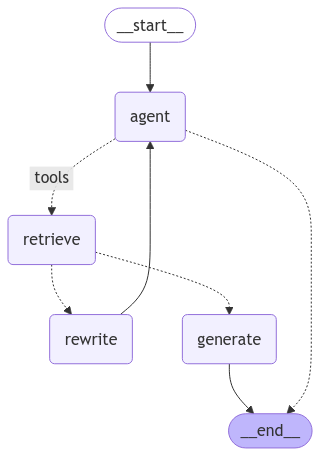

In [13]:
abot.display_graph()

In [7]:
messages = [HumanMessage(content="Explain it by demonstrating a simple example")]  
thread = {"configurable": {"thread_id": "1"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content="Let's consider a simple example to understand viscosity using honey and water:\n\nImagine you have two identical glasses, one filled with honey and the other with water. If you take a spoon and stir each glass, you will notice a significant difference in the effort required to stir. Stirring the water feels much easier compared to stirring the honey. This difference is due to the viscosity of the fluids.\n\nWater has a low viscosity, meaning it offers less resistance to objects moving through it. It flows easily and quickly when stirred. Honey, on the other hand, has a high viscosity. It is thicker and resists motion more than water, requiring more force to stir.\n\nThis example illustrates how viscosity affects the movement of objects through fluids and the fluid's resistance to changes in shape or motion.", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_f17929ee92

In [8]:
messages = [HumanMessage(content="So when i have bodywash on my hand and when i move my hand why did it slip immediately? my other bodywash doesn't slip immediately")]  
thread = {"configurable": {"thread_id": "1"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content='The slipping of bodywash from your hand can be attributed to differences in viscosity between the two products. The bodywash that slips off your hand immediately likely has a lower viscosity, making it more fluid and less resistant to motion. This allows it to flow more freely and slip off your hand quickly when you move it.\n\nOn the other hand, the bodywash that does not slip off immediately probably has a higher viscosity. It is thicker and adheres better to your skin, resisting motion and not slipping off as easily when you move your hand. This difference in behavior is directly related to the viscosity of each bodywash formulation, which can vary based on the ingredients and their concentrations used in the products.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_c936bae6c5'}, id='run-36a29337-dbc0-4972-828d-5c98d2e67c4b-0')]


In [9]:
messages = [HumanMessage(content="Tell me about the molecular origins of viscosity")]  
thread = {"configurable": {"thread_id": "1"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_KAigWsOBp6gbATApBMbXJ2uD', 'function': {'arguments': '{"query":"molecular origins of viscosity"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_f17929ee92'}, id='run-522c06f8-57c4-4bf6-8a83-a3df40a4aaa8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'molecular origins of viscosity'}, 'id': 'call_KAigWsOBp6gbATApBMbXJ2uD', 'type': 'tool_call'}])]
---CHECK RELEVANCE---


/Users/suras/Documents/ADSK/RAG_Template/.venv/lib/python3.9/site-packages/langchain_openai/chat_models/base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/suras/Documents/ADSK/RAG_Template/.venv/lib/python3.9/site-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-4-0125-preview since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
[ToolMessage(content='Molecular origins[edit]\nMomentum transport in gases is mediated by discrete molecular collisions, and in liquids by attractive forces that bind molecules close together.[19] Because of this, the dynamic viscosities of liquids are typically much larger than those of gases. In addition, viscosity tends to increase with temperature in gases and decrease with temperature in liquids.\n\nmolecular dynamics computer simulations. Somewhat more progress can be made for a dilute gas, as elementary assumptions about how gas molecules move and interact lead to a basic understanding of the molecular origins of viscosity. More sophisticated treatments can be constructed by systematically coarse-graining the equations of motion of the gas molecules. An example of such a treatment is Chapman–Enskog theory, which derives expressions for the viscosity of a dilute gas from the Boltzmann equation.[17]\n\nIn light of these shortcomings, the development o

In [10]:
messages = [HumanMessage(content="Tell me more about it")]  
thread = {"configurable": {"thread_id": "2"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content='Could you please specify what topic or subject you would like to know more about? This will help me provide you with the most relevant and detailed information.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_c936bae6c5'}, id='run-e6206054-58c1-44c0-9bcc-7a82a977f95f-0')]


In [12]:
messages = [HumanMessage(content="the body wash which slipped is more viscous than the one that didn't slip. why did it slip?")]  
thread = {"configurable": {"thread_id": "1"}}
  
for event in abot.graph.stream({"messages": messages}, thread):
  for v in event.values():
    print(v['messages'])

---CALL AGENT---
[AIMessage(content='If the bodywash that slipped off your hand is indeed more viscous, the explanation for why it slipped might seem counterintuitive at first, but it can be understood through a few key points about how viscosity works in practical scenarios:\n\n1. **Adhesion and Cohesion**: Viscous fluids often have strong cohesive forces, meaning the molecules within the fluid attract each other strongly. However, their adhesion to other materials (like your skin) might not be as strong. If the cohesive forces within the bodywash are stronger than the adhesive forces between the bodywash and your skin, the bodywash will tend to stay together as a mass and slip off when you move your hand.\n\n2. **Layering and Shear Thinning**: Some viscous fluids exhibit properties like shear thinning, where the viscosity decreases under stress. When you move your hand, the bodywash might experience shear thinning, becoming less viscous and more prone to slipping off as a result of t